In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/upi_synthetic.csv", parse_dates=["timestamp"])
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transaction_id  100000 non-null  int64         
 1   timestamp       100000 non-null  datetime64[ns]
 2   sender_id       100000 non-null  object        
 3   receiver_id     100000 non-null  object        
 4   amount          100000 non-null  float64       
 5   city            100000 non-null  object        
 6   message         100000 non-null  object        
 7   device_change   100000 non-null  int64         
 8   is_fraud        100000 non-null  int64         
 9   fraud_type      100000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 7.6+ MB


,transaction_id,timestamp,amount,device_change,is_fraud
count,100000.000000,100000,100000.000000,100000.000000,100000.000000
mean,49999.500000,2024-01-15 23:35:57.600630016,702.299839,0.080360,0.024280
min,0.000000,2024-01-01 00:00:24,1.000000,0.000000,0.000000
25%,24999.750000,2024-01-08 11:58:45,204.097500,0.000000,0.000000
50%,49999.500000,2024-01-15 23:41:09.500000,488.000000,0.000000,0.000000
75%,74999.250000,2024-01-23 11:47:56.249999872,972.592500,0.000000,0.000000
max,99999.000000,2024-01-31 00:00:00,8219.960000,1.000000,1.000000
std,28867.657797,NaN,700.727886,0.271851,0.153918


In [3]:

df['is_fraud'].value_counts(), df['is_fraud'].value_counts(normalize=True)


(is_fraud
 0    97572
 1     2428
 Name: count, dtype: int64,
 is_fraud
 0    0.97572
 1    0.02428
 Name: proportion, dtype: float64)

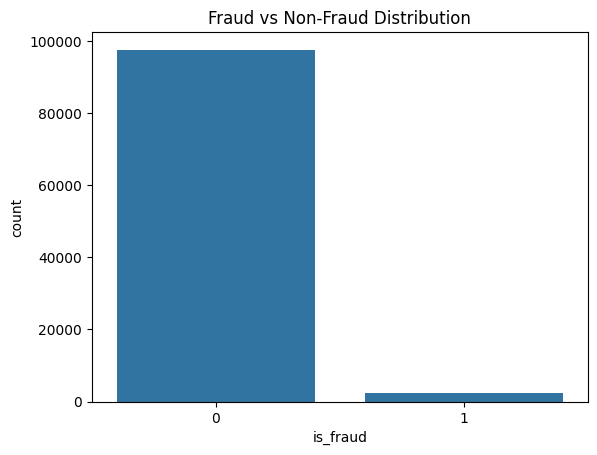

In [4]:
sns.countplot(data=df, x='is_fraud')
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


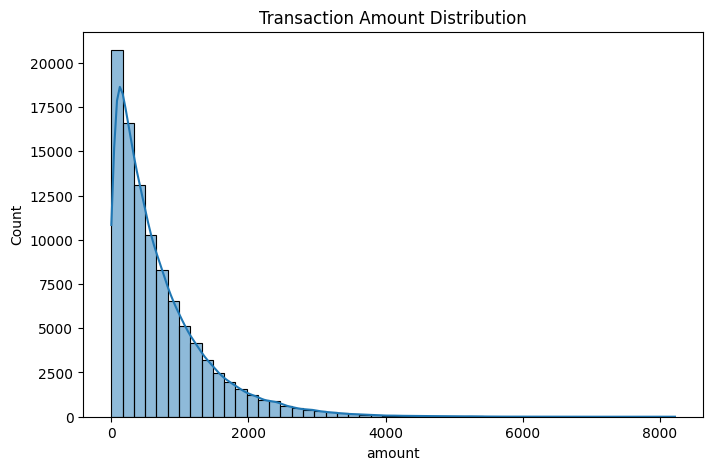

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


In [6]:
df[df.is_fraud == 1]['amount'].describe()


count    2428.000000
mean      725.867821
std       748.205371
min         1.020000
25%       201.002500
50%       499.600000
75%       978.330000
max      6120.840000
Name: amount, dtype: float64

In [7]:
df.sender_id.value_counts().head()


sender_id
user_1586    42
user_1483    38
user_3641    37
user_4892    36
user_2951    35
Name: count, dtype: int64

In [8]:
df.receiver_id.value_counts().head()


receiver_id
user_1871    43
user_2240    36
user_2562    35
user_4073    35
user_4370    35
Name: count, dtype: int64

In [9]:
df['hour'] = df.timestamp.dt.hour
df['dayofweek'] = df.timestamp.dt.day_name()


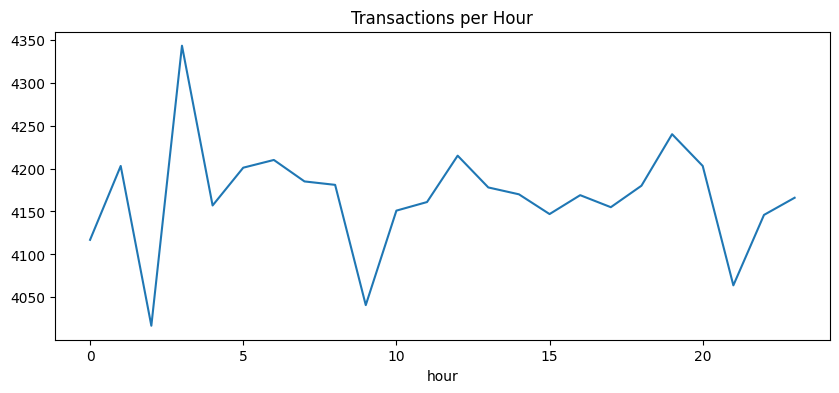

In [10]:
df.groupby('hour').size().plot(kind='line', figsize=(10,4))
plt.title("Transactions per Hour")
plt.show()


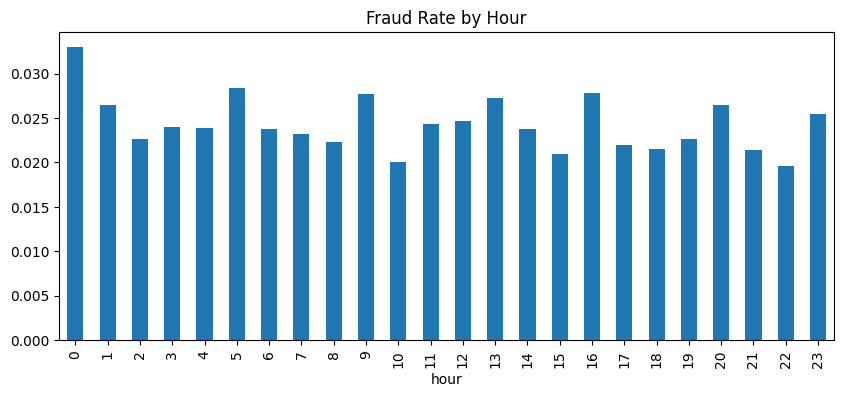

In [11]:
df.groupby('hour')['is_fraud'].mean().plot(kind='bar', figsize=(10,4))
plt.title("Fraud Rate by Hour")
plt.show()


In [15]:
# 1) ensure timestamp is datetime and data is time-ordered
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# 2) mark first-time a sender pays a particular receiver
# After sorting by time, duplicated(subset=['sender_id','receiver_id'])
# returns True for repeated sender→receiver pairs, so we invert it.
df['first_time_receiver'] = (~df.duplicated(subset=['sender_id','receiver_id'])).astype(int)

# 3) quick sanity checks
print(df[['timestamp','sender_id','receiver_id','first_time_receiver']].head(20))
print("First-time fraction (overall):", df['first_time_receiver'].mean())
print("First-time fraction by fraud label:")
print(df.groupby('is_fraud')['first_time_receiver'].mean())


             timestamp  sender_id receiver_id  first_time_receiver
0  2024-01-01 00:00:24  user_1299   user_4931                    1
1  2024-01-01 00:00:50   user_159   user_4456                    1
2  2024-01-01 00:00:57  user_1109   user_1715                    1
3  2024-01-01 00:01:12  user_4188   user_1669                    1
4  2024-01-01 00:01:50  user_4974   user_2801                    1
5  2024-01-01 00:02:03  user_1713   user_1538                    1
6  2024-01-01 00:02:25  user_2591   user_4407                    1
7  2024-01-01 00:02:37  user_1608   user_4560                    1
8  2024-01-01 00:02:40  user_1738   user_1850                    1
9  2024-01-01 00:03:27  user_4934   user_2695                    1
10 2024-01-01 00:03:38  user_3338   user_2931                    1
11 2024-01-01 00:06:24  user_3964   user_4152                    1
12 2024-01-01 00:06:43   user_592   user_1508                    1
13 2024-01-01 00:06:44  user_1059    user_171                 

In [16]:
df.groupby('is_fraud')['first_time_receiver'].mean()


is_fraud
0    0.997991
1    1.000000
Name: first_time_receiver, dtype: float64

In [17]:
df.groupby('device_change')['is_fraud'].mean()


device_change
0    0.02427
1    0.02439
Name: is_fraud, dtype: float64

In [18]:
df['contains_refund'] = df['message'].str.contains("refund|mistake|OTP|support", case=False)

df.groupby('contains_refund')['is_fraud'].mean()


contains_refund
False    0.014603
True     1.000000
Name: is_fraud, dtype: float64